


.........................initialize..........................
FileName: BB/BB_WS_identical_10_2_0_50000
Strains: 2
Using WS random graph model
Num of links: 400
Reverse ZERO: tensor(5.3179e-07, device='cuda:0')
Num links weight bigger than 0.1: tensor(0, device='cuda:0')
Num links weight bigger than 0.05: tensor(0, device='cuda:0')
Num links weight bigger than 0.01: tensor(345, device='cuda:0')
.............................................................


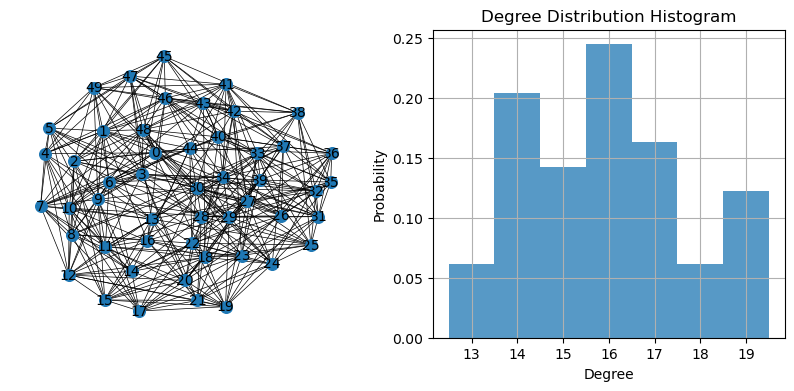

In [4]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import argparse
import modules.random_graph as random_graph
import logging
import modules.weight as weight
import modules.A_mat as A_mat
import modules.pramameters as pramameters
import modules.population as population
import modules.plotGraph as plotGraph
import modules.simulation as simulation
import modules.utils as utils
import modules.nn as nn
import modules.evaluate as evaluate

#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
#preset
paras.modelLoad= "BB"
paras.randomGraph= "WS"
paras.weightModel= "identical"
paras.epoches= 50000
paras.intense= 0
paras.seed= 10
paras.plot= "spring"
paras.strains= 2

# paras.epoches= 50000
# paras.randomGraph= "BA"
# paras.weightModel= "identical"
# paras.seed= 20
#paras.dense= 8


random.seed(paras.seed)

#results and logs file name
fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.randomGraph}_{paras.weightModel}_{paras.seed}_{paras.strains}_{paras.intense}_{paras.epoches}"

printFlag= 1
if printFlag!=1:
    logging.basicConfig(filename="logs/"+paras.modelLoad+".out", level=logging.INFO)

plotFlag= 1

device= paras.device if torch.cuda.is_available() else "cpu"


P= population.population(paras.n, device= device)

# generate random graphs: GEO(defult), ER, WS, BA'
if paras.randomGraph=="GEO":
    A, G, pos= random_graph.get_Geo_random_contact(paras.n, radius=0.4, device= device)
elif paras.randomGraph=="BA":
    A, G= random_graph.get_BA_random_contact(paras.n, paras.dense, device= device)
elif paras.randomGraph=="WS":
    A, G= random_graph.get_WS_random_contact(paras.n, paras.dense*2, 0.3,device= device)
elif paras.randomGraph=="ER":
    A, G= random_graph.get_ER_random_contact(paras.n, paras.dense, device= device)

#assign adjacency weight to matrix: degree(defult), gravity

if paras.weightModel=="degree":
    Aw= weight.degree_model(A, P= P, device=device)
elif  paras.weightModel=="gravity":
    Aw= weight.gravity_model(G, pos, P, device= device)
elif  paras.weightModel=="identical":
    Aw= weight.identical_model(A, 0.01, device= device)

utils.log_print(printFlag,"\n\n\n.........................initialize..........................")
utils.log_print(printFlag,"FileName:", fileName)
utils.log_print(printFlag,"Strains:", paras.strains)
utils.log_print(printFlag,"Using", paras.randomGraph,"random graph model")
utils.log_print(printFlag,"Num of links:", G.number_of_edges())
Zmat= A_mat.create_A_mat(Aw, P)
Zmat2= A_mat.reverse_A_mat(Zmat-torch.eye(Aw.shape[0], dtype= torch.float32, device= Aw.device), P)
utils.log_print(printFlag,"Reverse ZERO:", torch.sum(torch.abs(Zmat2-Aw)))
utils.log_print(printFlag,"Num links weight bigger than 0.1:", torch.sum(Zmat>0.1)-paras.n)
utils.log_print(printFlag,"Num links weight bigger than 0.05:", torch.sum(Zmat>0.05)-paras.n)
utils.log_print(printFlag,"Num links weight bigger than 0.01:", torch.sum(Zmat>0.01)-paras.n)
utils.log_print(printFlag,".............................................................")
#plot this network
if plotFlag==1:
    if paras.plot== "2d_geo":
        plotGraph.plot_2d_geo(G, pos)
    elif paras.plot== "spring":
        plotGraph.plot_spring_layout(G)

[8.453814455016, 8.039240229981667, 8.769377919507692, 8.56612925005294, 8.352074398297274, 8.497927306062849, 8.094667195003492, 8.282235429179693, 8.159706547006571, 8.270968964376033, 8.380928945474295, 8.121729915503767, 8.785557807457675, 8.524440587810666, 8.533299837793166, 8.283109357657741, 8.188914221883469, 8.00262507277432, 8.649950925092906, 8.676243338388058, 8.718331736748398, 8.77761253102664, 8.458242900768232, 8.495496939765989, 8.447302107322807, 8.204747835501207, 7.990767375275774, 8.02937007572428, 8.031267994072854, 8.634639343325055, 8.512298222858288, 8.607712124275979, 8.457325087864161, 8.529377081129843, 8.596040603416807, 8.519893488239829, 8.34071891310076, 8.71829879751455, 8.49064724232536, 8.671331594333358]
[6.232898364805973, 6.203047982921621, 6.194675323035005, 6.1701051448587085, 6.255748368598094, 6.219473835557776, 6.111290891628539, 6.244548791223472, 6.245304954703511, 6.113971495863372, 6.209833831723281, 6.139820621915175, 6.217126902087992, 

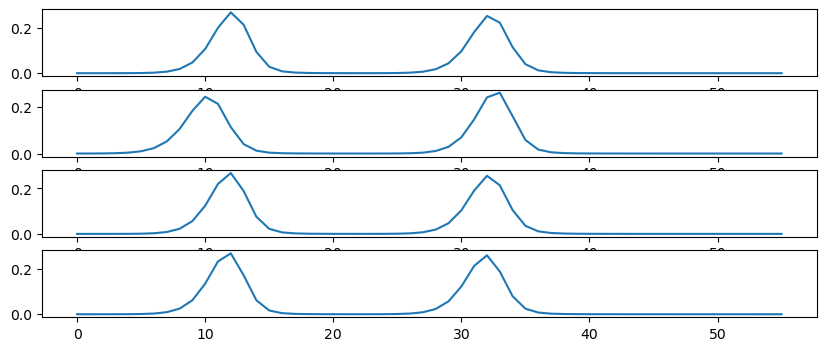

In [5]:
R0s_taus= [[random.uniform(paras.R0Mean-paras.R0Std, paras.R0Mean+paras.R0Std), 
            random.uniform(paras.tauMean-paras.tauStd, paras.tauMean+paras.tauStd)] for _ in range(40)]
paras.R0s=  [ R0s_taus[i][0] for i in range(40)]
paras.taus= [ R0s_taus[i][1] for i in range(40)]
utils.log_print(printFlag,paras.R0s)
utils.log_print(printFlag,paras.taus)
deltaSsTensor= simulation.multi_strains(G, paras, Zmat, intense= paras.intense, device= device)
deltaSs= deltaSsTensor.sum(dim= -1, keepdim= True)
propition= deltaSsTensor/(deltaSs+1e-8)
deltaSs= deltaSs.squeeze()#(1, 2, 20), dim of nodes, dim of heads, dim of signal
divide= deltaSsTensor.transpose(1, 2)
utils.log_print(printFlag,divide.shape)
if plotFlag==1:
    numPlot= 4
    fig, axs = plt.subplots(numPlot, 1, figsize=(10, 4))
    for i, ax in enumerate(axs):
        ax.plot(deltaSs[i, :].cpu().detach())
    # plt.xlabel("Time(days)")
    # plt.ylabel("Propotion of newly infective")
    # plt.title(f"Example of {numPlot} nodes epidemic newly infected.")

In [6]:

timeHorizon= divide.shape[2]-1
if   paras.modelLoad=="AA":
    myMatch= nn.matchingA(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= nn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AB":
    myMatch= nn.matchingA(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= nn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BA":
    myMatch= nn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= nn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BB":
    myMatch= nn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= nn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="infer2018":
    myMatch= nn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= nn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)

    
optimizer1 = torch.optim.Adam(myMatch.parameters(),lr=1e-3)
optimizer2 = torch.optim.Adam({myEpi.taus},lr=2e-4)
optimizer3 = torch.optim.Adam({myEpi.R0dTaus},lr=2e-4)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []
if paras.modelLoad in ["infer2018", "AB", "BB"]:
    threshold_value= 0.1
    hook = nn.ThresholdHook(threshold_value)
    myEpi.taus.register_hook(hook)
    hook = nn.ThresholdHook(threshold_value)
    myEpi.R0dTaus.register_hook(hook)

In [7]:
if paras.modelLoad== "infer2018":
    for j in (range(paras.epoches)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        inferZmat= myMatch(divide, paras.modelLoad)
        predSignal, signal, PreZ= myEpi(divide, inferZmat)
        tempEye= torch.eye(paras.n, device= device)
        loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()+1e-5*torch.sum(torch.log(torch.sum(PreZ-tempEye, dim= 1)))
        losses.append((loss-1e-5*torch.sum(torch.log(torch.sum(PreZ-tempEye, dim= 1)))).item())
        if torch.isnan(loss).any():
            utils.log_print(printFlag, f"meet nan value at {j}")#
            break
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
else:
    for j in (range(paras.epoches)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        inferZmat= myMatch(divide, paras.modelLoad)
        predSignal, signal, PreZ= myEpi(divide, inferZmat)
        loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()
        if torch.isnan(loss).any():
            utils.log_print(printFlag, f"meet nan value at {j}")#
            break
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()

  0%|          | 2/50000 [00:00<1:12:18, 11.52it/s]

  1%|          | 309/50000 [00:14<39:00, 21.23it/s]  


KeyboardInterrupt: 

In [9]:
print(1e-3*torch.sum(torch.log(torch.sum(inferZmat, dim= 1))))

tensor(-0.1330, device='cuda:0', grad_fn=<MulBackward0>)


In [12]:
print(inferZmat.sum(dim=1))

tensor([0.4774, 0.1943, 0.0252, 0.1306, 0.1166, 0.0290, 0.1584, 0.1668, 0.0958,
        0.4694, 0.2196, 0.1821, 0.3045, 0.3749, 0.1911, 0.1940, 0.1133, 0.1889,
        0.1382, 0.2422, 0.2184, 0.1960, 0.0884, 0.1064, 0.1386, 0.1063, 0.0929,
        0.1034, 0.1162, 0.0783, 0.0918, 0.0662, 0.1059, 0.0986, 0.1144, 0.0821,
        0.0828, 0.0779, 0.0720, 0.0640, 0.0732, 0.0699, 0.1078, 0.0643, 0.0688,
        0.0688, 0.0677, 0.0710, 0.0707, 0.0670], device='cuda:0',
       grad_fn=<SumBackward1>)


In [10]:

#save: A, preA, losses, taus, pretaus, R0s, preR0s, [errors]
thred= 1e-3
utils.log_print(printFlag,paras.taus[0: paras.strains])
utils.log_print(printFlag,paras.R0s[0: paras.strains])
utils.log_print(printFlag,myEpi.taus[0])
utils.log_print(printFlag,(myEpi.taus*myEpi.R0dTaus)[0])
PreA= A_mat.reverse_A_mat(PreZ-torch.eye(paras.n, device= device), P)
IMatrix= torch.eye(paras.n, device= device)
utils.log_print(printFlag,"err1:", torch.sqrt((PreA-Aw)**2).sum())
utils.log_print(printFlag,"err2:", ((PreA>thred)^(Aw>thred)).sum())
utils.log_print(printFlag,"cosine similarity:", evaluate.cosine_similarity(Aw, PreA))
utils.log_print(printFlag,"cosine similarity 2:", evaluate.cosine_similarity((Aw>thred)+IMatrix, (PreA>thred)+IMatrix))
utils.log_print(printFlag,"spectral_analysis:", evaluate.spectral_analysis(Aw, PreA))
utils.log_print(printFlag,"spectral_analysis 2:", evaluate.spectral_analysis((Aw>thred)+IMatrix, (PreA>thred)+IMatrix))
utils.log_print(printFlag,"edge_correctness:", evaluate.edge_correctness((Aw>thred)+IMatrix, (PreA>thred)+IMatrix))
utils.log_print(printFlag,"jaccard_index:", evaluate.jaccard_index((Aw>thred)+IMatrix, (PreA>thred)+IMatrix))
utils.log_print(printFlag,torch.var(myEpi.taus, dim= 0))
utils.log_print(printFlag,torch.var(myEpi.R0dTaus, dim= 0))
utils.log_print(printFlag,torch.sum(predSignal[29, :, 0:-1])/paras.strains)
utils.log_print(printFlag,torch.sum(signal[29, :, 1:])/paras.strains)
startV= 5
deltaV= 7
utils.log_print(printFlag,PreA[startV:startV+deltaV, startV:startV+deltaV])
utils.log_print(printFlag,Aw[startV:startV+deltaV, startV:startV+deltaV])
np.savez("results/"+fileName+".npz", A= Aw.cpu().detach(), Apre= PreA.cpu().detach(), 
         cosine_similarity= evaluate.cosine_similarity(Aw, PreA).item(),
         loss= losses, taus= paras.taus, r0s= paras.R0s, tausP= myEpi.taus.cpu().detach(), 
         r0sP= (myEpi.R0dTaus*myEpi.taus).cpu().detach(), signal= signal.cpu().detach(), predSignal= predSignal.cpu().detach())


[6.22704142322114, 6.185530558043086, 6.242609109072898]
[8.37579279884445, 8.553688696902043, 8.30975918878567]
tensor([6.0833, 5.9314, 6.1580], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([8.4499, 8.4794, 8.4092], device='cuda:0', grad_fn=<SelectBackward0>)
err1: tensor(9.5014, device='cuda:0', grad_fn=<SumBackward0>)
err2: tensor(1130, device='cuda:0')
cosine similarity: tensor(0.2421, device='cuda:0', grad_fn=<DivBackward0>)
cosine similarity 2: tensor(0.5176, device='cuda:0')
spectral_analysis: tensor(0.4621, device='cuda:0', grad_fn=<DivBackward0>)
edge_correctness: tensor(0.7723, device='cuda:0')
jaccard_index: tensor(0.3147, device='cuda:0')
tensor([1.0738e-06, 9.1837e-07, 6.9123e-07], device='cuda:0',
       grad_fn=<VarBackward0>)
tensor([0.0003, 0.0003, 0.0003], device='cuda:0', grad_fn=<VarBackward0>)
tensor(0.9959, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9966, device='cuda:0')
tensor([[0.0000e+00, 2.2975e-04, 6.7043e-04, 1.6751e-08, 2.0110e-03, 4.2300e-03]

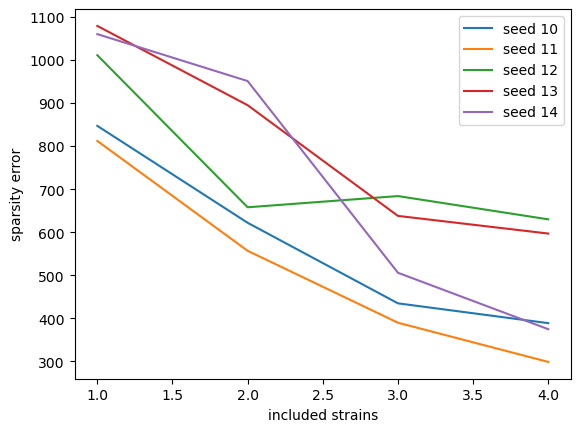

In [45]:
plt.plot([i+1 for i in range(4)],err2s.T, label=["seed 10", "seed 11", "seed 12", "seed 13", "seed 14"])
plt.ylabel("sparsity error")
plt.xlabel("included strains")
plt.legend()

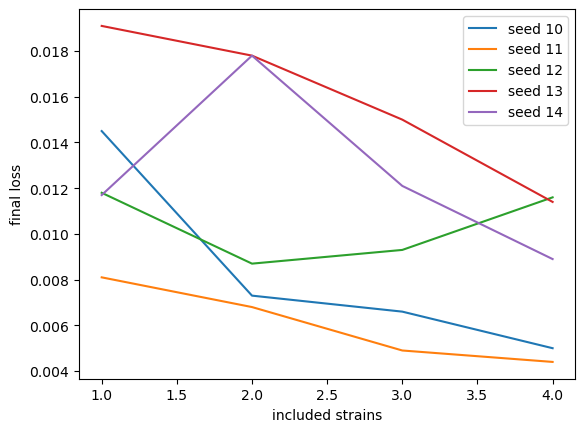

In [43]:
plt.plot([i+1 for i in range(4)],finalLoss.T, label=["seed 10", "seed 11", "seed 12", "seed 13", "seed 14"])
plt.ylabel("final loss")
plt.xlabel("included strains")
plt.legend()

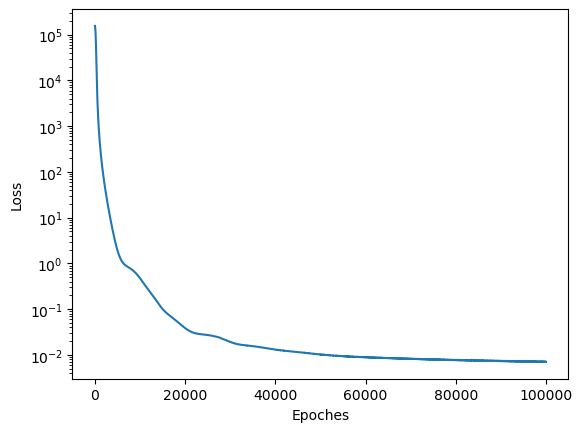

In [11]:
if plotFlag==1:
    plt.plot(losses)
    plt.yscale("log")
    plt.ylabel("Loss")
    plt.xlabel("Epoches")

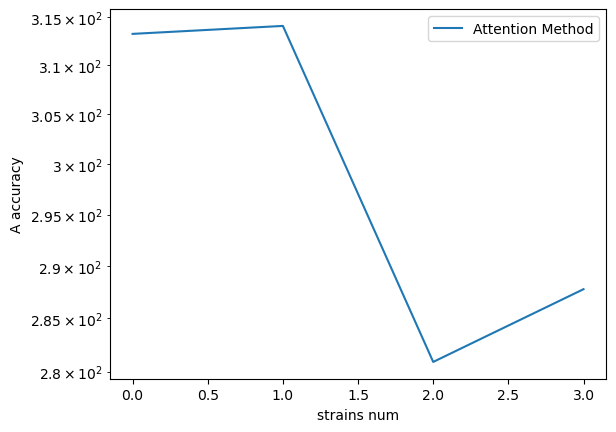

In [413]:
plt.plot(exper, label= "Attention Method")
#plt.plot(exper2, label= "Direct Method")
plt.xlabel("strains num")
plt.ylabel("A accuracy")
plt.yscale("log")
plt.legend()

tensor(0., device='cuda:0')
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)


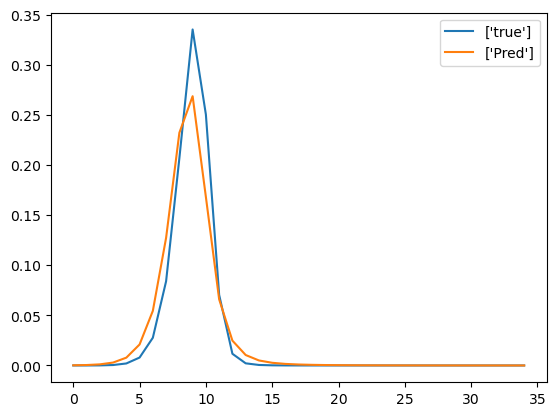

In [195]:
if plotFlag==1:
    node= 4
    plt.plot(signal[node, :, 1:].squeeze().T.cpu().detach(), label=paras.strains*["true"])
    utils.log_print(printFlag,signal[node, 0, 1])
    utils.log_print(printFlag,predSignal[node, 0, 0])
    #plt.plot(embedded_tensor[0, :, -1:].squeeze().T.cpu().detach())
    plt.plot(predSignal[node, :, 0:-1].squeeze().T.cpu().detach(), label=paras.strains*["Pred"])
    #plt.plot(noise[0].T.cpu().detach())
    plt.legend()